In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [ ]:
train_data_dir = '/content/drive/MyDrive/myOutput'
validation_data_dir = '/content/drive/MyDrive/myOutput'
batch_size=1
img_width,img_height =500,500

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.3,
    horizontal_flip=True,
    rotation_range = 2,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    validation_split = 0.3
)

In [ ]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset = "training",
        class_mode='categorical',
        )

Found 171 images belonging to 5 classes.


In [ ]:
#train_generator.samples


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset = "validation",
        class_mode='categorical',
        )

Found 70 images belonging to 5 classes.


In [ ]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (500,500,3))

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 15, 15, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.add(Dense(8192,activation=('relu'),input_dim=4096))
#model.add(Dense(4096,activation=('relu'))) 

#model.add(Dense(2048,activation=('relu'))) 

#model.add(Dense(5,activation=('softmax'))) 
#model.summary()
#--------------
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dropout(.4))
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dense(5,activation=('softmax'))) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 15, 15, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              117965824 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
batch_size= batch_size
epochs=500
learn_rate=.00001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',optimizer = 'adam' ,metrics=['categorical_accuracy'])

In [ ]:
import tensorflow as tf
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
from keras.callbacks import History
my_callback = MyThresholdCallback(threshold=0.8)
history = History()
model.fit_generator(
        train_generator,
        steps_per_epoch = int(171/batch_size),
        epochs = epochs,
        callbacks = [history, my_callback],
        verbose = 1,
        validation_data = validation_generator,
        validation_steps=int(70/batch_size),
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
171/171 [==============================] - 119s 649ms/step - loss: 1.7520 - accuracy: 0.2024 - val_loss: 1.6540 - val_accuracy: 0.2143
Epoch 2/500
171/171 [==============================] - 27s 158ms/step - loss: 1.7085 - accuracy: 0.1993 - val_loss: 1.6280 - val_accuracy: 0.2143
Epoch 3/500
171/171 [==============================] - 27s 158ms/step - loss: 1.6468 - accuracy: 0.2813 - val_loss: 1.6070 - val_accuracy: 0.2143
Epoch 4/500
171/171 [==============================] - 27s 156ms/step - loss: 1.7090 - accuracy: 0.1504 - val_loss: 1.6160 - val_accuracy: 0.2143
Epoch 5/500
171/171 [==============================] - 27s 157ms/step - loss: 1.6908 - accuracy: 0.1129 - val_loss: 1.6232 - val_accuracy: 0.2000
Epoch 6/500
171/171 [==============================] - 27s 157ms/step - loss: 1.6367 - accuracy: 0.1768 - val_loss: 1.6068 - val_accuracy: 0.2429
Epoch 7/500
171/171 [==============================] - 27s 156ms/step - loss: 1.6574 - accuracy: 0.2085 - val_loss: 1.6100 

In [ ]:
model.save('/content/drive/MyDrive/SavedModels')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SavedModels/assets


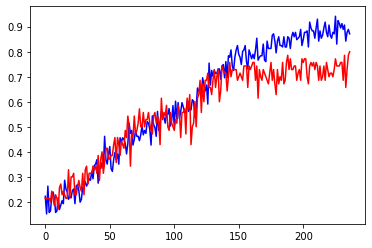

In [ ]:
ax=plt.subplots(1,1) 
#Loss
#ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
#ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]


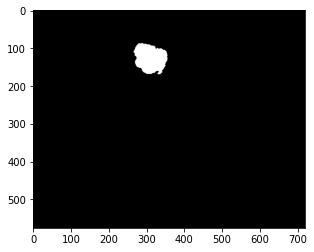

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=500
img_height=500
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(500, 500))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/drive/MyDrive/TestImageBaso.bmp')])
img = image.load_img('/content/drive/MyDrive/TestImageBaso.bmp')
plt.imshow(img)
print (result)